# Ensure SerpAPI is imported

In [2]:
!pip install google-search-results
!pip install fredapi

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=5d4726d7931391a78048a6a88446c8d497b24b8df41d42214ef0d9d2a62ce1a5
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results


# Graphics Cards Price Comparison
What are the prices of some of the most popular graphics cards?

Searching for relevant GPU data using SerpAPI...


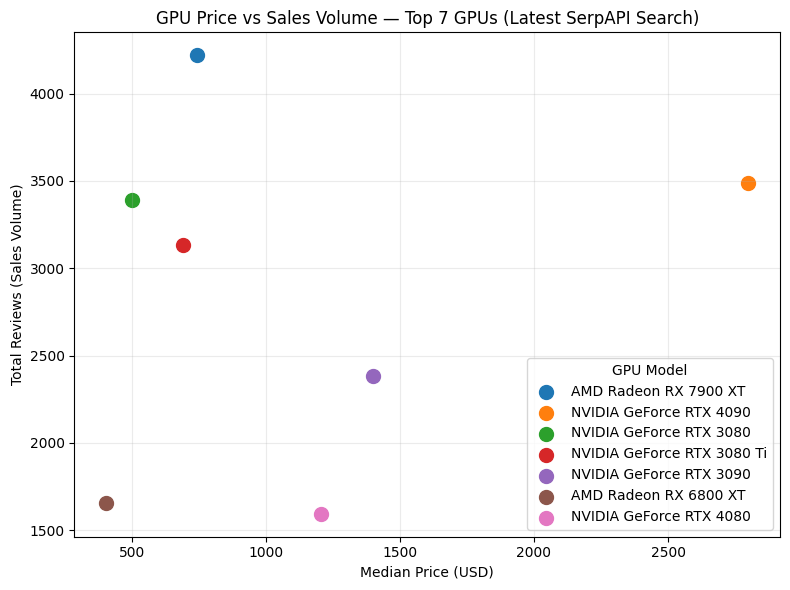

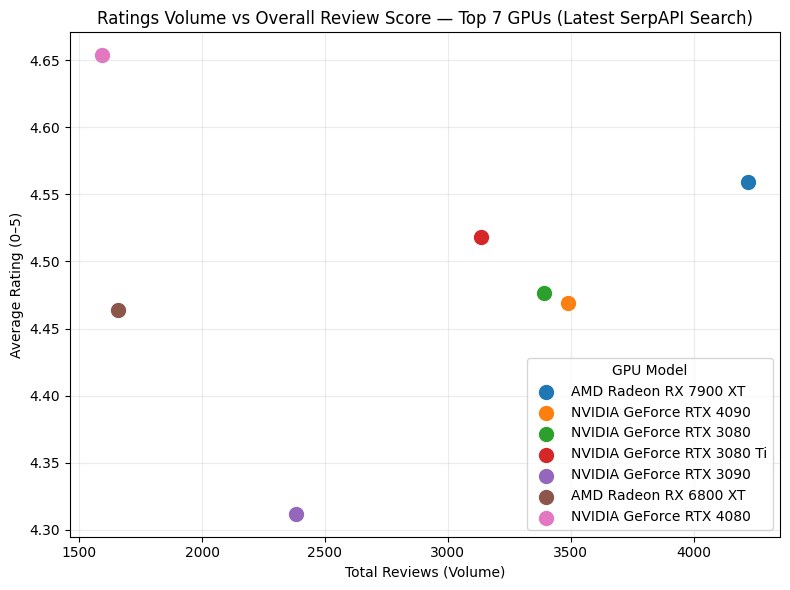

Fetching FRED series WPU5841 since 2020-01-01...


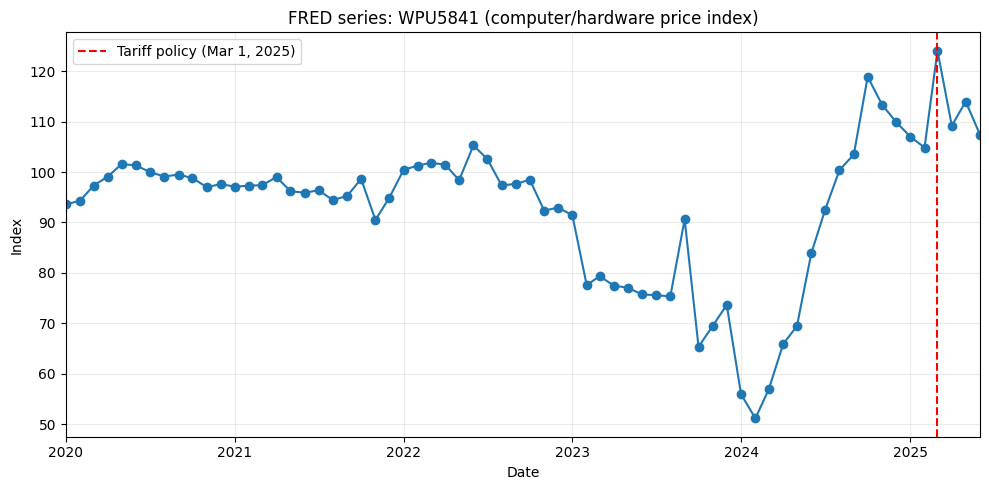

In [15]:
# Author: Stas Litvak
import os
import time
import datetime as dt
import math
import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from fredapi import Fred
import requests

# CONFIG
SERPAPI_API_KEY = "b484735aff7d4281635c4e98dabddeb9e8fff811b87264da95c846d48386e966"
FRED_API_KEY = "e3a98eb469aa0274d69879357df6d096"

# GPUs to track
GPU_MODELS = [
    "NVIDIA GeForce RTX 3080",
    "NVIDIA GeForce RTX 3080 Ti",
    "NVIDIA GeForce RTX 3090",
    "NVIDIA GeForce RTX 4080",
    "NVIDIA GeForce RTX 4090",
    "AMD Radeon RX 6800 XT",
    "AMD Radeon RX 7900 XT",
]

# FRED series to use as macro price index for "computers/hardware"
# Uses 'WPU5841' (Producer Price Index by Commodity: Computer Hardware, Software, and Supplies Retailing)
FRED_SERIES_ID = "WPU5841"

# Tariff policy event date to mark on charts
TARIFF_DATE = dt.datetime(2025, 3, 1)  # March 1, 2025

# Set arbitrary date for COVID start (for plots)
COVID_START = dt.datetime(2020, 1, 1)

# Helper: SerpAPI shopping search for a specific GPU model
# Returns a list of product dicts with price, old_price, rating, reviews, source
def serpapi_get_shopping_for_model(model_name, serpapi_key):
    params = {
        "engine": "google_shopping",
        "q": model_name,
        "hl": "en",
        "gl": "us",
        "api_key": serpapi_key,
    }
    search = GoogleSearch(params)
    result = search.get_dict()

    shopping_results = result.get("shopping_results", [])
    if not isinstance(shopping_results, list):
        shopping_results = []

    parsed = []
    for item in shopping_results:
        # SerpAPI sometimes returns extracted_price, sometimes price string
        def parse_price(p):
            if not p:
                return None
            s = str(p).replace("$", "").replace(",", "").strip()
            try:
                return float(s)
            except:
                import re
                m = re.search(r"(\d[\d,]*\.?\d*)", s)
                return float(m.group(1).replace(",", "")) if m else None

        price = parse_price(item.get("extracted_price") or item.get("price"))
        old_price = parse_price(item.get("extracted_old_price") or item.get("old_price"))

        rating = item.get("rating")
        reviews = item.get("reviews")
        try:
            rating = float(rating) if rating is not None else None
        except:
            rating = None
        try:
            reviews = int(str(reviews).replace(",", "")) if reviews is not None else None
        except:
            reviews = None

        parsed.append({
            "title": item.get("title"),
            "source": item.get("source"),
            "price": price,
            "old_price": old_price,
            "rating": rating,
            "reviews": reviews,
            "retrieved_at": dt.datetime.utcnow()
        })
    return parsed

# -------------------------
# Step 1: Query SerpAPI for each GPU, build 2 dataframes
# -------------------------
def snapshot_gpu_prices(gpu_models, serpapi_key):
    rows = []
    for model in gpu_models:
        try:
            results = serpapi_get_shopping_for_model(model, serpapi_key)
        except Exception as e:
            print(f"SerpAPI error for {model}: {e}")
            results = []
        # compute simple aggregates: median price across listings, weighted rating
        prices = [r["price"] for r in results if r["price"] is not None]
        avg_price = float(pd.Series(prices).median()) if prices else None
        # weighted rating across found listings
        num = sum([ (r["rating"] or 0) * (r["reviews"] or 0) for r in results if r.get("rating") is not None and r.get("reviews") is not None ])
        den = sum([ r["reviews"] for r in results if r.get("reviews") is not None ])
        weighted_rating = (num / den) if den else None
        tot_reviews = den if den else 0
        rows.append({
            "model": model,
            "snapshot_date": dt.datetime.utcnow(),
            "median_price": avg_price,
            "listings_count": len(results),
            "weighted_rating": weighted_rating,
            "total_reviews": tot_reviews
        })
        # be polite: short pause
        time.sleep(1.0)
    return pd.DataFrame(rows)

# -------------------------
# Step 2: Pull FRED series (monthly)
# -------------------------
def fetch_fred_series(fred_key, series_id, start_date):
    fred = Fred(api_key=fred_key)
    ser = fred.get_series(series_id, observation_start=start_date.strftime("%Y-%m-%d"))
    df = pd.DataFrame({"date": ser.index, "index": ser.values})
    df["date"] = pd.to_datetime(df["date"])
    return df


# Plotting: GPU price trends, macro FRED series
def plot_from_serpapi(raw_results_df):
    # Aggregate to one entry per GPU model
    agg_df = (
        raw_results_df.groupby("model", as_index=False)
        .agg({
            "price": "median",     # Median price to avoid extreme outliers
            "reviews": "sum",      # Total reviews (sales volume proxy)
            "rating": "mean"       # Average rating
        })
    )

    # Pick top 7 GPUs by total reviews
    top_df = agg_df.sort_values("reviews", ascending=False).head(7).reset_index(drop=True)

    # Distinct colors for exactly 7 GPUs. Picks first 7 colors from tab10 list to
    # ensure distinctness
    colors = plt.cm.tab10.colors[:7]

    # --- 1) Price vs Sales Volume ---
    plt.figure(figsize=(8, 6))
    for i, row in top_df.iterrows():
        plt.scatter(row["price"], row["reviews"], color=colors[i], s=100, label=row["model"])

    plt.xlabel("Median Price (USD)")
    plt.ylabel("Total Reviews (Sales Volume)")
    plt.title("GPU Price vs Sales Volume — Top 7 GPUs (Latest SerpAPI Search)")

    # "loc" param allows for legend placement to be fluid
    plt.legend(title="GPU Model", loc="best")

    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # --- 2) Ratings Volume vs Overall Review Score ---
    plt.figure(figsize=(8, 6))
    for i, row in top_df.iterrows():
        plt.scatter(row["reviews"], row["rating"], color=colors[i], s=100, label=row["model"])

    plt.xlabel("Total Reviews (Volume)")
    plt.ylabel("Average Rating (0–5)")
    plt.title("Ratings Volume vs Overall Review Score — Top 7 GPUs (Latest SerpAPI Search)")
    plt.legend(title="GPU Model", loc="best")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()


# -------------------------
# Main Function
# -------------------------
def main():
    if not SERPAPI_API_KEY:
        raise SystemExit("Set SERPAPI_API_KEY environment variable or edit the script.")
    if not FRED_API_KEY:
        raise SystemExit("Set FRED_API_KEY environment variable or edit the script.")

    print("Searching for relevant GPU data using SerpAPI...")

    all_rows = []
    for model in GPU_MODELS:
        try:
            listings = serpapi_get_shopping_for_model(model, SERPAPI_API_KEY)
        except Exception as e:
            print(f"SerpAPI error for {model}: {e}")
            listings = []
        for item in listings:
            all_rows.append({
                "model": model,
                "price": item["price"],
                "reviews": item["reviews"],
                "rating": item["rating"]
            })
        time.sleep(1.0)

    raw_results_df = pd.DataFrame(all_rows)

    plot_from_serpapi(raw_results_df)

    # Fetch and plot FRED index
    print(f"Fetching FRED series {FRED_SERIES_ID} since 2020-01-01...")
    fred_df = fetch_fred_series(FRED_API_KEY, FRED_SERIES_ID, COVID_START)
    plt.figure(figsize=(10, 5))
    plt.plot(fred_df["date"], fred_df["index"], marker="o")
    plt.axvline(TARIFF_DATE, linestyle="--", linewidth=1.5, color="red",
                label="Tariff policy (Mar 1, 2025)")
    plt.xlim(COVID_START, fred_df["date"].max())
    plt.xlabel("Date")
    plt.ylabel("Index")
    plt.title(f"FRED series: {FRED_SERIES_ID} (computer/hardware price index)")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
